In [1]:
#!/usr/bin/env python3
import sys
import os
import numpy as np
import nibabel as nib
from scipy import stats
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.image import math_img, threshold_img

In [2]:
def load_and_stack_files(file_list):
    """Load and stack all input files into a 4D array"""
    images = []
    for f in file_list:
        img = nib.load(f.strip())
        images.append(img.get_fdata())
    
    # Stack all subjects along the first dimension
    stacked_data = np.stack(images, axis=0)
    return stacked_data, img.affine, img.header

def group_t_test(stacked_data):
    """Perform group-level t-test for each voxel"""
    n_subjects = stacked_data.shape[0]
    
    # Calculate t-statistics (one-sample t-test against 0)
    t_stats = np.zeros(stacked_data.shape[1:])
    for idx in np.ndindex(stacked_data.shape[1:]):
        voxel_data = stacked_data[(slice(None),) + idx]
        if np.all(voxel_data == 0):  # Skip zero voxels
            continue
        t_stats[idx] = stats.ttest_1samp(voxel_data, popmean=0).statistic
    
    # Convert to z-statistics
    z_stats = np.zeros_like(t_stats)
    valid_mask = np.isfinite(t_stats)
    z_stats[valid_mask] = stats.norm.ppf(stats.t.cdf(np.abs(t_stats[valid_mask]), 
                                        df=n_subjects-1))
    
    return t_stats, z_stats

def save_results(t_stats, z_stats, affine, header, output_prefix):
    """Save t-stat and z-stat maps as NIfTI files"""
    # Save t-stat map
    t_img = nib.Nifti1Image(t_stats, affine, header)
    nib.save(t_img, f"output2/{output_prefix}.tstat.nii.gz")
    
    # Save z-stat map
    z_img = nib.Nifti1Image(z_stats, affine, header)
    nib.save(z_img, f"output2/{output_prefix}.zstat.nii.gz")

In [14]:
def main():
    # if len(sys.argv) != 3:
    #     print("Usage: python group_analysis.py <file_list.txt> <output_prefix>")
    #     print("Example: python group_analysis.py cope_files.txt group_results")
    #     sys.exit(1)
    
    file_list_path = "grp_list.txt"
    output_prefix = "output1"
    
    # Read input file list
    with open(file_list_path, 'r') as f:
        file_list = f.readlines()
    
    # 1. Load and process data
    print("Loading and stacking input files...")
    stacked_data, affine, header = load_and_stack_files(file_list)
    
    # 2. Perform group analysis
    print("Running group-level t-tests...")
    t_stats, z_stats = group_t_test(stacked_data)
    
    # 3. Save results
    print("Saving results...")
    save_results(t_stats, z_stats, affine, header, output_prefix)
    
    # # 4. Compare with FSL (if available)
    # fsl_zstat = output_prefix.replace('custom', 'fsl') + '.zstat.nii.gz'
    # if os.path.exists(fsl_zstat):
    #     print("Comparing with FSL results...")
    #     compare_with_fsl(f"{output_prefix}.zstat.nii.gz", fsl_zstat)
    
    print(f"Group analysis complete! Results saved with prefix: {output_prefix}")



In [15]:
if __name__ == "__main__":
    main()

Loading and stacking input files...
Running group-level t-tests...
Saving results...
Group analysis complete! Results saved with prefix: output1


In [20]:
def compare_with_fsl(custom_zstat, fsl_zstat, output_dir='group_comparison/Cope3'):
    """Robust comparison function that handles all edge cases"""
    from nilearn.image import resample_to_img, threshold_img, math_img
    import numpy as np
    import nibabel as nib
    import matplotlib.pyplot as plt
    from nilearn import plotting
    import os
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        # 1. Load and prepare images
        fsl_img = nib.load(fsl_zstat)
        custom_img = nib.load(custom_zstat)
        
        # Resample if dimensions don't match
        if fsl_img.shape != custom_img.shape:
            print(f"Resampling custom image (shape {custom_img.shape}) to match FSL (shape {fsl_img.shape})")
            custom_img = resample_to_img(custom_img, fsl_img, interpolation='continuous')
        
        # Get data arrays
        fsl_data = fsl_img.get_fdata()
        custom_data = custom_img.get_fdata()
        
        # 2. Quantitative comparison
        valid_mask = (
            np.isfinite(fsl_data) & 
            np.isfinite(custom_data) & 
            (fsl_data != 0) & 
            (custom_data != 0)
        )
        
        if np.sum(valid_mask) == 0:
            raise ValueError("No valid voxels found for comparison")
        
        fsl_vals = fsl_data[valid_mask]
        custom_vals = custom_data[valid_mask]
        
        # Calculate comparison metrics
        corr_coef = np.corrcoef(fsl_vals, custom_vals)[0, 1]
        mean_diff = np.mean(fsl_vals - custom_vals)
        max_diff = np.max(np.abs(fsl_vals - custom_vals))
        
        # 3. Visualization
        
        # Determine automatic cut coordinates
        if fsl_img.shape == (91, 109, 91):  # Standard MNI dimensions
            cut_coords = (0, -17, 9)  # Good slices for MNI brain
        else:
            # Calculate center of mass for non-standard images
            non_zero = fsl_data > 0
            if np.any(non_zero):
                cut_coords = tuple(np.mean(np.where(non_zero), axis=1).astype(int))
            else:
                cut_coords = tuple(s//2 for s in fsl_img.shape)
        
        # Create figures
        
        # Scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(fsl_vals, custom_vals, alpha=0.3, s=10)
        lims = [np.min([fsl_vals.min(), custom_vals.min()]), 
                np.max([fsl_vals.max(), custom_vals.max()])]
        plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        plt.xlabel('FSL t-stat values')
        plt.ylabel('Our t-stat values')
        plt.title(f't-stat Comparison\nr = {corr_coef:.3f}, Mean Δ = {mean_diff:.3f}, Max |Δ| = {max_diff:.3f}')
        plt.grid(True)
        plt.savefig(f"{output_dir}/tstat_scatter.png", bbox_inches='tight', dpi=300)
        plt.close()
        
        # Determine visualization threshold
        try:
            threshold = max(
                np.percentile(fsl_data[fsl_data > 0], 95),
                np.percentile(custom_data[custom_data > 0], 95),
                2.3  # Minimum threshold
            )
        except:
            threshold = 2.3
        
        # Brain maps comparison
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        plotting.plot_stat_map(
            threshold_img(fsl_img, threshold=threshold),
            title='FSL t-stat',
            axes=axes[0],
            display_mode='ortho',
            cut_coords=cut_coords,
            colorbar=True,
            vmax=threshold*1.5
        )
        
        plotting.plot_stat_map(
            threshold_img(custom_img, threshold=threshold),
            title='Our t-stat',
            axes=axes[1],
            display_mode='ortho',
            cut_coords=cut_coords,
            colorbar=True,
            vmax=threshold*1.5
        )
        plt.savefig(f"{output_dir}/tstat_brainmaps.png", bbox_inches='tight', dpi=150)
        plt.close()
        
        # Difference map
        diff_img = math_img("img1 - img2", img1=fsl_img, img2=custom_img)
        plotting.plot_stat_map(
            diff_img,
            title='Difference (FSL - Custom)',
            display_mode='ortho',
            cut_coords=cut_coords,
            colorbar=True
        )
        plt.savefig(f"{output_dir}/tstat_difference.png", bbox_inches='tight', dpi=150)
        plt.close()
        
        print(f"Successfully created comparison plots in {output_dir}")
        
    except Exception as e:
        print(f"Error during comparison: {str(e)}")
        raise

In [21]:
fsl = "output2/output1.gfeat/cope3.feat/stats/tstat1.nii.gz"
our = "output2/output3.tstat.nii.gz"
compare_with_fsl(our, fsl)

Resampling custom image (shape (64, 64, 40)) to match FSL (shape (91, 109, 91))


C:\Users\ch720\AppData\Local\Temp\ipykernel_12332\2567070489.py:21: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  custom_img = resample_to_img(custom_img, fsl_img, interpolation='continuous')
c:\Users\ch720\AppData\Local\Programs\Python\Python39\lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
C:\Users\ch720\AppData\Local\Temp\ipykernel_12332\2567070489.py:88: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`

Successfully created comparison plots in group_comparison/Cope3


In [24]:
def show_brain_maps(fsl_file, my_file, slice_index, title, output_file):
    fsl_img = nib.load(fsl_file).get_fdata()
    my_img = nib.load(my_file).get_fdata()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    vmin = -5
    vmax = 5
    axes[0].imshow(np.rot90(fsl_img[:, :, slice_index]), cmap='hot', vmin=vmin, vmax=vmax)
    axes[0].set_title("FSL")
    axes[0].axis("off")

    axes[1].imshow(np.rot90(my_img[:, :, slice_index]), cmap='hot', vmin=vmin, vmax=vmax)
    axes[1].set_title("Our Tool")
    axes[1].axis("off")

    fig.suptitle(title)
    plt.savefig(output_file)
    plt.show()


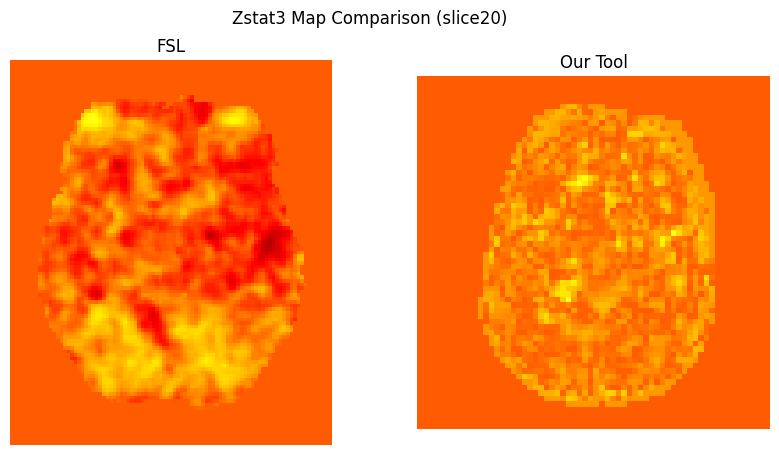

In [35]:
fsl = "output2/output1.gfeat/cope3.feat/stats/zstat1.nii.gz"
our = "output2/output3.zstat.nii.gz"

show_brain_maps(fsl, our, 
                slice_index=30, 
                title="Zstat3 Map Comparison (slice20)", 
                output_file="group_comparison/Cope3/Zstat3_map_20.png")